In [3]:

# 导入本地数据集
import os, shutil

# 注意文件的位置！！！！！！！！！！！
base_dir = "/kaggle/input/dogsimages/dogImages"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

train_Affenpinscher_dir = os.path.join(train_dir, '001.Affenpinscher')


In [4]:
print("have", len(os.listdir(train_Affenpinscher_dir)))

have 64


In [5]:
# 迁移学习 导入模型VGG19
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
conv_base.trainable = False
conv_base.summary()


80142336/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [6]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
 
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)
 
    
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=32,
        class_mode='categorical') 
 
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


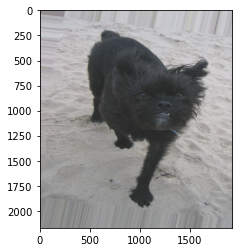

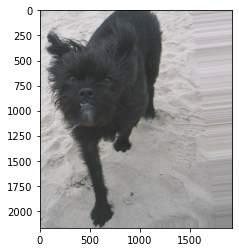

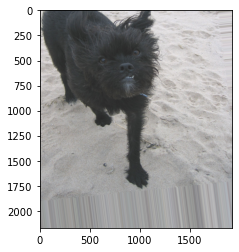

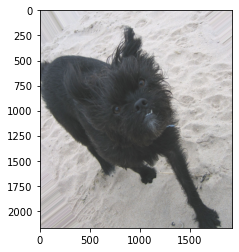

In [7]:
# 数据增强
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

fnames = [os.path.join(train_Affenpinscher_dir, fname) for fname in os.listdir(train_Affenpinscher_dir)]

img_path = fnames[3]
img = load_img(img_path)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
 
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break  # otherwise the generator would loop indefinitely

In [8]:
# 增加全连接层实现分类
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(133, activation='softmax'))

model.summary()

from keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)              

In [9]:

# 训练 并保存模型权重
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='dogsclassification.augmentation.model.weights.best.hdf5', verbose=1,
                               save_best_only=True)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[checkpointer],
    verbose=2)


Epoch 1/30
 - 135s - loss: 5.1849 - accuracy: 0.0103 - val_loss: 4.8733 - val_accuracy: 0.0146

Epoch 00001: val_loss improved from inf to 4.87334, saving model to dogsclassification.augmentation.model.weights.best.hdf5
Epoch 2/30
 - 123s - loss: 4.9333 - accuracy: 0.0100 - val_loss: 4.8182 - val_accuracy: 0.0156

Epoch 00002: val_loss improved from 4.87334 to 4.81819, saving model to dogsclassification.augmentation.model.weights.best.hdf5
Epoch 3/30
 - 117s - loss: 4.9102 - accuracy: 0.0088 - val_loss: 4.8881 - val_accuracy: 0.0097

Epoch 00003: val_loss did not improve from 4.81819
Epoch 4/30
 - 117s - loss: 4.8923 - accuracy: 0.0110 - val_loss: 4.8867 - val_accuracy: 0.0117

Epoch 00004: val_loss did not improve from 4.81819
Epoch 5/30
 - 115s - loss: 4.8818 - accuracy: 0.0103 - val_loss: 4.8847 - val_accuracy: 0.0097

Epoch 00005: val_loss did not improve from 4.81819
Epoch 6/30
 - 113s - loss: 4.8807 - accuracy: 0.0128 - val_loss: 4.8269 - val_accuracy: 0.0104

Epoch 00006: val_lo

In [10]:
# 导出模型  测试正确率
model.load_weights('dogsclassification.augmentation.model.weights.best.hdf5')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)


Found 836 images belonging to 133 classes.
test acc: 0.07228915393352509


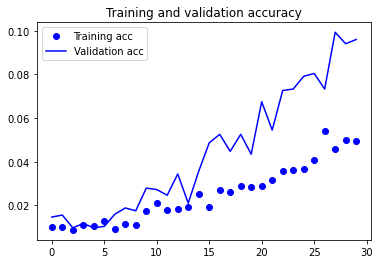

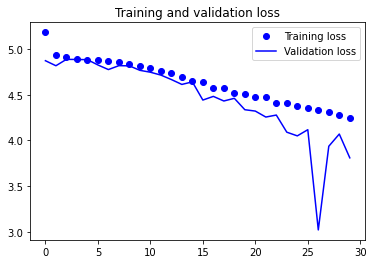

In [11]:
# 画图显示
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [12]:
model.save('model.h5')

In [13]:
from keras.models import load_model
model = load_model('model.h5')


/opt/conda/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [14]:
checkpointer = ModelCheckpoint(filepath='dogsclassification.augmentation.model.weights.best.hdf5', verbose=1,
                               save_best_only=True)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[checkpointer],
    verbose=2)

Epoch 1/50
 - 131s - loss: 4.9056 - accuracy: 0.0088 - val_loss: 4.9088 - val_accuracy: 0.0108

Epoch 00001: val_loss improved from inf to 4.90882, saving model to dogsclassification.augmentation.model.weights.best.hdf5
Epoch 2/50
 - 124s - loss: 4.8846 - accuracy: 0.0113 - val_loss: 4.8760 - val_accuracy: 0.0117

Epoch 00002: val_loss improved from 4.90882 to 4.87597, saving model to dogsclassification.augmentation.model.weights.best.hdf5
Epoch 3/50
 - 124s - loss: 4.8804 - accuracy: 0.0078 - val_loss: 4.8775 - val_accuracy: 0.0097

Epoch 00003: val_loss did not improve from 4.87597
Epoch 4/50
 - 120s - loss: 4.8829 - accuracy: 0.0116 - val_loss: 4.8978 - val_accuracy: 0.0084

Epoch 00004: val_loss did not improve from 4.87597
Epoch 5/50
 - 121s - loss: 4.8828 - accuracy: 0.0091 - val_loss: 4.8907 - val_accuracy: 0.0117

Epoch 00005: val_loss did not improve from 4.87597
Epoch 6/50
 - 119s - loss: 4.8790 - accuracy: 0.0116 - val_loss: 4.7743 - val_accuracy: 0.0052

Epoch 00006: val_lo


Epoch 00048: val_loss improved from 0.61231 to 0.51726, saving model to dogsclassification.augmentation.model.weights.best.hdf5
Epoch 49/50
 - 129s - loss: 0.3998 - accuracy: 0.8737 - val_loss: 0.8358 - val_accuracy: 0.7399

Epoch 00049: val_loss did not improve from 0.51726
Epoch 50/50
 - 122s - loss: 0.5130 - accuracy: 0.8484 - val_loss: 0.5729 - val_accuracy: 0.7633

Epoch 00050: val_loss did not improve from 0.51726


In [15]:
# model.save('model.h5')
# model = load_model('model.h5')
# checkpointer = ModelCheckpoint(filepath='dogsclassification.augmentation.model.weights.best.hdf5', verbose=1,
#                                save_best_only=True)
# history = model.fit_generator(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=100,
#     validation_data=validation_generator,
#     validation_steps=50,
#     callbacks=[checkpointer],
#     verbose=2)

In [16]:
model.save('model.h5')

In [17]:
model.load_weights('dogsclassification.augmentation.model.weights.best.hdf5')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.736947774887085


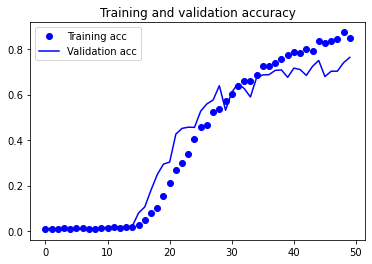

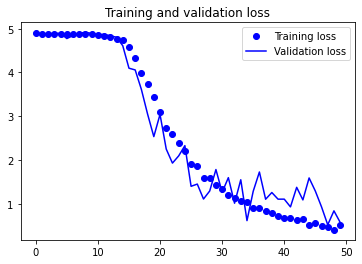

In [18]:
# 画图显示
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


a
